In [27]:
import pandas as pd
import glob
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
import datetime
import warnings
warnings.simplefilter("ignore")

In [32]:
def get_articles(name):
    dictio = {}
    list_of_files = glob.glob('../data/news/'+name+'/*.txt')        
    for i,file_name in enumerate(list_of_files):
        id_article = file_name[:-4].split('/')[4]
        dictio[int(id_article)] = open(file_name,'r').read()
    return dictio

def get_words(content):
    vectorizer = TfidfVectorizer(min_df=1,lowercase=True,stop_words='english')
    vectorizer.fit_transform(content.split('.'))
    return vectorizer.get_feature_names()

def get_features(df):
    df['len_content'] = df['content'].apply(lambda x : len(x))
    global_vectorizer = TfidfVectorizer(min_df=0.15,max_df=0.95,lowercase=True,stop_words='english',max_features=500)
    global_vectorizer.fit_transform(df['content'])
    pertinent_vocab = global_vectorizer.get_feature_names()
    article_vocab = [get_words(content) for content in df['content']]
    df['nb_relevant'] = [len (set(vocab) & set(pertinent_vocab)) for vocab in article_vocab]
    return df.drop(['content'], axis = 'columns')

def get_Y_train():
    true_val = []
    indexes = []
    articles = open('../data/labels_training.txt','r').readlines()[1:]
    for i in articles:
        true_val.append(int(i.split(',')[1][:-1]))
        indexes.append(int(i.split(',')[0]))
    return pd.DataFrame(true_val,columns=['fake_news'],index=indexes)

def rmse(y_true, y_pred):
    return metrics.mean_squared_error(y_true, y_pred) ** 0.5

### Get articles for training and testing

In [33]:
train = get_articles('training')
test = get_articles('test')

### Transform to dataframe

In [34]:
df_train = pd.DataFrame.from_dict(train,orient='index',columns=['content'])
df_test = pd.DataFrame.from_dict(test,orient='index',columns=['content'])

### Features engineering

In [35]:
df_train = get_features(df_train)
df_test = get_features(df_test)

### Some graphs

Text(0, 0.5, 'Nb caracters')

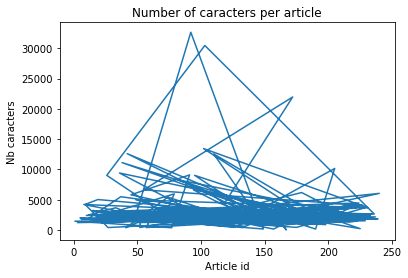

In [36]:
plt.plot(df_train['len_content'])
plt.title('Number of caracters per article')
plt.xlabel('Article id')
plt.ylabel('Nb caracters')

Text(0, 0.5, 'Nb relevants words')

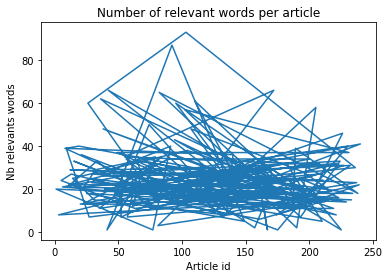

In [37]:
plt.plot(df_train['nb_relevant'])
plt.title('Number of relevant words per article')
plt.xlabel('Article id')
plt.ylabel('Nb relevants words')

### It's prediction time !

Choose the best algorihm

In [40]:
X_train = df_train.sort_index()
Y_train = get_Y_train().sort_index()
X_test = df_test

In [41]:
clf = DecisionTreeClassifier()
clf.fit(X_train,Y_train)
Y_test = clf.predict(X_test)

### Create a submission file

In [42]:
now = str(datetime.datetime.now())[:19]
with open('../data/submissions/bogota_mates_submission_'+now+'.txt', 'w') as f:
    f.write('doc,class\n')
    for value,doc in zip(Y_test,X_test.index):
        f.write(str(doc)+ ',' + str(value)+"\n")